In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils.np_utils import to_categorical

from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.preprocessing import LabelEncoder  
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras import layers

from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU,Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten,GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

from keras.models import Model
from keras.optimizers import RMSprop
plt.style.use('fivethirtyeight')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_excel('/content/drive/My Drive/Master thesis/DataSet-forUsing/1- AJCommentsClassification-hateORnot.xlsx')
print("Sample from dataset",data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31159 entries, 0 to 31158
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    31159 non-null  object
 1   label   31159 non-null  object
dtypes: object(2)
memory usage: 487.0+ KB
Sample from dataset None


In [5]:
data.head()

,body,label
0,يبغي التنبيه على ان السعودية تستخدم صواريخ جو-...,hate
1,أمريكا قتلت بالامس معوق رفض رفع يديه فماذا تري...,hate
2,هذا الشخص هو من كان مؤيد لاحتلال العراق وضرب ا...,hate
3,الى جمال ريان مذيع الجزيرة نحن من رعاك فى المه...,hate
4,خيبة الأمل ليست تشاؤما ولا تقولا ٠\nعزم لكفالة...,not-hate


In [6]:
data.isna().sum()

body     0
label    0
dtype: int64

In [7]:
data.shape

(31159, 2)

In [8]:
# data.dropna(axis=0,inplace=True)

In [9]:
# data.shape

(31159, 2)

In [11]:
# data["tweet"].duplicated().sum()

In [10]:
# bool_series = data["tweet"].duplicated() 
# data[bool_series][:12]

In [12]:
# data.loc[data['tweet'] == "تحمل اللاجئون السوريون شدة البرد والحر"]

In [14]:
# data.shape

In [15]:
# data.drop_duplicates(subset=['tweet'],inplace=True)

In [16]:
# len(data.sentiment.unique())

In [17]:
# data.sentiment.value_counts()

In [20]:
data_df=data[['body', 'label']]

In [19]:
# data_df.shape

(31159, 2)

In [21]:
# data_df["sentiment"] = data_df.apply(lambda x: "Not-HS" if x["sentiment"] == 'normal' else "HS",axis =1)

In [23]:
# data_df.head()

In [24]:
data_df.label.value_counts()

hate        25506
not-hate     5653
Name: label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Hate and Normal tweets')

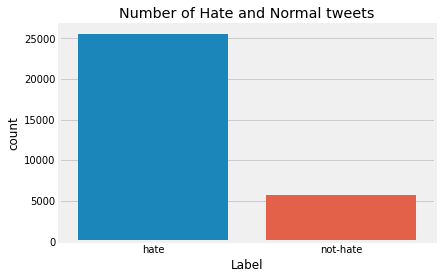

In [26]:
sns.countplot(data_df.label)
plt.xlabel('Label')
plt.title('Number of Hate and Normal tweets')

In [27]:
le = LabelEncoder()   
data_df['label']= le.fit_transform(data_df['label']) 

In [28]:
data_df.head()

,body,label
0,يبغي التنبيه على ان السعودية تستخدم صواريخ جو-...,0
1,أمريكا قتلت بالامس معوق رفض رفع يديه فماذا تري...,0
2,هذا الشخص هو من كان مؤيد لاحتلال العراق وضرب ا...,0
3,الى جمال ريان مذيع الجزيرة نحن من رعاك فى المه...,0
4,خيبة الأمل ليست تشاؤما ولا تقولا ٠\nعزم لكفالة...,1


In [29]:
val_df = data_df.sample(frac=0.1, random_state=1007)
train_df = data_df.drop(val_df.index)
test_df = train_df.sample(frac=0.1, random_state=1007)
train_df.drop(test_df.index, inplace=True)
(train_df.shape,val_df.shape,test_df.shape)

((25239, 2), (3116, 2), (2804, 2))

In [30]:
x_train=train_df['body']
y_train=train_df['label']
x_val=val_df['body']
y_val=val_df['label']
x_test=test_df['body']
y_test=test_df['label']

In [31]:
x_train.head()

0    يبغي التنبيه على ان السعودية تستخدم صواريخ جو-...
1    أمريكا قتلت بالامس معوق رفض رفع يديه فماذا تري...
2    هذا الشخص هو من كان مؤيد لاحتلال العراق وضرب ا...
4    خيبة الأمل ليست تشاؤما ولا تقولا ٠\nعزم لكفالة...
5          سفينة الأكاذيب  والنفاق  والفاسد والاستبداد
Name: body, dtype: object

In [32]:

#prepare a tokenizer for abstract on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert abstract sequences into integer sequences
x_train   =   x_tokenizer.texts_to_sequences(x_train) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)
x_test = x_tokenizer.texts_to_sequences(x_test)
#padding zero upto maximum length
x_train    =   pad_sequences(x_train, padding='post') 
x_val     =   pad_sequences(x_val, padding='post')
x_test = pad_sequences(x_test,padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1
print("Size of vocabulary in x = {}".format(x_voc_size))

Size of vocabulary in x = 88220


In [33]:
x_train[:1]

array([[19376, 31164,     4,     8,    32,  5400,  1963,  4449,   384,
        14089, 19377, 14090, 31165,    11,  7778,     3,  7779,     3,
        31166, 14091, 31167, 31168,     3,    46,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)

In [34]:
x_train.shape

(25239, 46)

# First model | Bidirectional RNN

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(x_voc_size, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         11292160  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 11,436,482
Trainable params: 11,436,482
Non-trainable params: 0
____________________________________________

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

history=model.fit(x_train, y_train, epochs=50, batch_size=128,callbacks=[es])


Epoch 1/50
198/198 [==============================] - 56s 281ms/step - loss: 2.6113 - accuracy: 0.4838
Epoch 2/50
198/198 [==============================] - 55s 279ms/step - loss: 2.3460 - accuracy: 0.4796
Epoch 3/50
198/198 [==============================] - 55s 279ms/step - loss: 1.7982 - accuracy: 0.4700
Epoch 4/50
198/198 [==============================] - 61s 310ms/step - loss: 0.9076 - accuracy: 0.4661
Epoch 5/50
198/198 [==============================] - 55s 278ms/step - loss: 0.4996 - accuracy: 0.5193
Epoch 6/50
198/198 [==============================] - 55s 278ms/step - loss: 0.3998 - accuracy: 0.4642
Epoch 7/50
198/198 [==============================] - 55s 278ms/step - loss: 0.3687 - accuracy: 0.5251
Epoch 8/50
198/198 [==============================] - 55s 279ms/step - loss: 0.3455 - accuracy: 0.4018
Epoch 9/50
198/198 [==============================] - 56s 281ms/step - loss: 0.2834 - accuracy: 0.3455
Epoch 10/50
198/198 [==============================] - 56s 282ms/step - l

In [39]:
y_predict = model.predict(x_test)
# print(y_predict)
predictions = (np.array(y_predict) > 0.5).astype(np.int)
predictions.flatten().tolist()
# prediction

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


# Second Model  | CNN +GRU

In [40]:
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.optimizers import Adam

model2= Sequential()
model2.add(Embedding(x_voc_size,128,input_length= x_train.shape[1]))
model2.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.25))
model2.add(GRU(128,return_sequences=True))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 128)           11292160  
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 64)            24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 23, 128)           74496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2944)             

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

history=model2.fit(x_train, y_train, epochs=10, batch_size=128,callbacks=[es])


Epoch 1/10
198/198 [==============================] - 41s 205ms/step - loss: 0.6932 - accuracy: 0.6089
Epoch 2/10
198/198 [==============================] - 41s 205ms/step - loss: 0.6931 - accuracy: 0.6691
Epoch 3/10
198/198 [==============================] - 41s 207ms/step - loss: 0.6931 - accuracy: 0.7266
Epoch 00003: early stopping


# Third Model | Bidirectional GRU

In [42]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(x_voc_size, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model3.summary()
model3.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1)
history=model3.fit(x_train, y_train, epochs=10,batch_size=128,callbacks=[es])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         11292160  
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         198144    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 11,787,266
Trainable params: 11,787,266
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
198/198 [==============================] - 137s 690ms/step - loss: 0.6932 - accuracy: 0.4996
Epoc

# Forth Model | LSTM

In [43]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(x_voc_size, 128),
    tf.keras.layers.SpatialDropout1D(0.4),
    tf.keras.layers.LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True),
    tf.keras.layers.LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False),
    tf.keras.layers.Dense(2,activation='softmax')
])
model4.summary()
model4.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1)
history=model4.fit(x_train, y_train, epochs=10,batch_size=128,callbacks=[es])
# model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
# model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         11292160  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 11,354,050
Trainable params: 11,354,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
198/198 [==============================] - 68s 342ms/step - loss: 0.6932 - accuracy: 0.5045
Epoch